In [1]:
%pylab inline
import numpy as np
from numpy.fft import fft2,ifft2
import itertools
from SparseARD import*
from AICc_Training import *
import json
np.random.seed(0)

retrain = False

Populating the interactive namespace from numpy and matplotlib


In [2]:
m = 250 # number of samples
n = 2  # dimension of input    
p = 30  # degree of fourier basis in each direction
s = 50  # number of nonzero terms
noise_percent = 10
n_trials = 10

tol = 1e-5 # tolerance for ARD algorithm
verbose = False

frequencies = list(itertools.product(np.arange(p),np.arange(p)))
feature_maps = [lambda x,c=f: np.prod([np.cos(x[:,i]*c[i]).reshape(x.shape[0],1) \
                                       for i in range(n)],axis=0) for f in frequencies]
d = len(feature_maps)
print(d)

900


In [3]:
if retrain:
    
    L1_err = {'ARD' : [], 'ARDr' : [], 'ARDvi' : [], 'mSTSBL' : [], 'lSTSBL' : [], 'dSTSBL' : []}
    L2_err = {'ARD' : [], 'ARDr' : [], 'ARDvi' : [], 'mSTSBL' : [], 'lSTSBL' : [], 'dSTSBL' : []}
    Added = {'ARD' : [], 'ARDr' : [], 'ARDvi' : [], 'mSTSBL' : [], 'lSTSBL' : [], 'dSTSBL' : []}
    Missed = {'ARD' : [], 'ARDr' : [], 'ARDvi' : [], 'mSTSBL' : [], 'lSTSBL' : [], 'dSTSBL' : []}
    
    for trial in range(n_trials):
    
        print('Trial', trial+1, 'of', str(n_trials)+'.')

        # Get random matrix
        X = np.pi*np.random.rand(m,n)
        Theta = np.hstack([f(X) for f in feature_maps])

        nnz = np.random.choice(d,s,replace=False)
        xi = np.zeros((d,1))
        xi[nnz,0] = np.random.randn(s)
        y0 = Theta.dot(xi)
        sigma = 0.01*noise_percent*np.std(y0)
        y = y0 + sigma*np.random.randn(m,1)

        # Test each method
        gamma_ARD,sigma2_ARD,mu_xi_ARD,_ = SBL([Theta,y], \
                                           sigma2=1, \
                                           estimate_sigma=True, \
                                           maxit=500, \
                                           verbose=verbose, \
                                           tol=tol)
        AICc_ARD = AICc(Theta,y,gamma_ARD,sigma2_ARD)
        ARD_results = gamma_ARD,sigma2_ARD,mu_xi_ARD,AICc_ARD

        gamma_ARDr, sigma2_ARDr, mu_xi_ARDr = Train_ARDr(Theta,y,ARD_results=ARD_results,lams = [0,1e-2,1e-1,1e0,1e1,1e2])
        gamma_ARDvi, sigma2_ARDvi, mu_xi_ARDvi = Train_ARDvi(Theta, y, ARD_results=ARD_results)
        gamma_STSBL, sigma2_STSBL, mu_xi_STSBL = Train_M_STSBL(Theta, y, ARD_results=ARD_results)
        gamma_lSTSBL, sigma2_lSTSBL, mu_xi_lSTSBL = Train_L_STSBL(Theta, y, ARD_results=ARD_results)
        gamma_dSTSBL, sigma2_dSTSBL, mu_xi_dSTSBL = Train_MAP_STSBL(Theta, y, ARD_results=ARD_results)

        # Record errors
        L1_err['ARD'].append(np.linalg.norm(xi - mu_xi_ARD, 1))
        L1_err['ARDr'].append(np.linalg.norm(xi - mu_xi_ARDr, 1))
        L1_err['ARDvi'].append(np.linalg.norm(xi - mu_xi_ARDvi, 1))
        L1_err['mSTSBL'].append(np.linalg.norm(xi - mu_xi_STSBL, 1))
        L1_err['lSTSBL'].append(np.linalg.norm(xi - mu_xi_lSTSBL, 1))
        L1_err['dSTSBL'].append(np.linalg.norm(xi - mu_xi_dSTSBL, 1))

        L2_err['ARD'].append(np.linalg.norm(xi - mu_xi_ARD, 2))
        L2_err['ARDr'].append(np.linalg.norm(xi - mu_xi_ARDr, 2))
        L2_err['ARDvi'].append(np.linalg.norm(xi - mu_xi_ARDvi, 2))
        L2_err['mSTSBL'].append(np.linalg.norm(xi - mu_xi_STSBL, 2))
        L2_err['lSTSBL'].append(np.linalg.norm(xi - mu_xi_lSTSBL, 2))
        L2_err['dSTSBL'].append(np.linalg.norm(xi - mu_xi_dSTSBL, 2))

        _,added,missed = sparsity_err(mu_xi_ARD,xi)
        Added['ARD'].append(added)
        Missed['ARD'].append(missed)

        _,added,missed = sparsity_err(mu_xi_ARDr,xi)
        Added['ARDr'].append(added)
        Missed['ARDr'].append(missed)

        _,added,missed = sparsity_err(mu_xi_ARDvi,xi)
        Added['ARDvi'].append(added)
        Missed['ARDvi'].append(missed)

        _,added,missed = sparsity_err(mu_xi_STSBL,xi)
        Added['mSTSBL'].append(added)
        Missed['mSTSBL'].append(missed)

        _,added,missed = sparsity_err(mu_xi_lSTSBL,xi)
        Added['lSTSBL'].append(added)
        Missed['lSTSBL'].append(missed)

        _,added,missed = sparsity_err(mu_xi_dSTSBL,xi)
        Added['dSTSBL'].append(added)
        Missed['dSTSBL'].append(missed)

In [4]:
if retrain:
    with open('./saved_results/Function_fitting_results.json','w') as f:
        json.dump({'L2_err': L2_err, \
                   'L1_err': L1_err, \
                   'Added' : Added, \
                   'Missed' : Missed}, f)
else:
    with open('./saved_results/Function_fitting_results.json','r') as f:
        results = json.load(f)
    L2_err = results['L2_err']    
    L1_err = results['L1_err']    
    Added = results['Added']
    Missed = results['Missed']

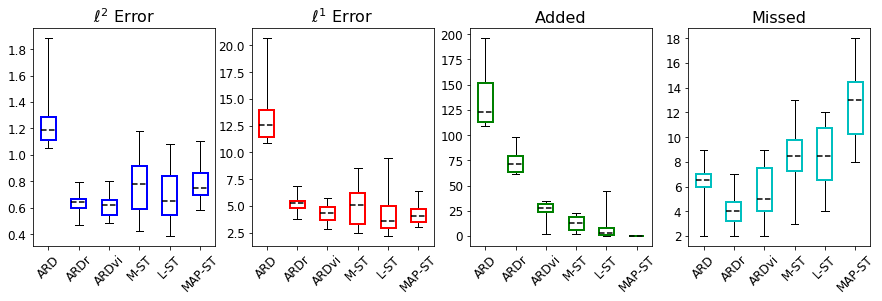

In [5]:
figure(figsize = (15,4))

lw = 2
label_fs = 16

whis = [0,100]
showfliers = False

subplot(1,4,1)
title(r'$\ell^2$ Error', fontsize = 16)
bp1 = boxplot([L2_err[key] for key in L2_err.keys()], positions = np.arange(6), \
              patch_artist=True, whis=whis, showfliers=showfliers)
for box, whisker,cap in zip(bp1['boxes'], bp1['whiskers'], bp1['caps']):
    box.set(color='blue', linewidth=lw)
    box.set(facecolor = 'w' )
yticks(fontsize = 12)
xticks(np.arange(6), ['ARD','ARDr','ARDvi','M-ST','L-ST','MAP-ST'], fontsize = 12, rotation=45)

for median in bp1['medians']:
    median.set(color='k', linestyle = '--', linewidth=1.5)

##########################################################################################
##########################################################################################
##########################################################################################

subplot(1,4,2)
title(r'$\ell^1$ Error', fontsize = 16)
bp2 = boxplot([L1_err[key] for key in L1_err.keys()], positions = np.arange(6), patch_artist=True, whis=whis, showfliers=showfliers)
for box, whisker, cap in zip(bp2['boxes'], bp2['whiskers'], bp2['caps']):
    box.set(color='red', linewidth=lw)
    box.set(facecolor = 'w' )
yticks(fontsize = 12)
xticks(np.arange(6), ['ARD','ARDr','ARDvi','M-ST','L-ST','MAP-ST'], fontsize = 12, rotation=45)

for median in bp2['medians']:
    median.set(color='k', linestyle = '--', linewidth=1.5)

##########################################################################################
##########################################################################################
##########################################################################################

subplot(1,4,3)
title(r'Added', fontsize = 16)
bp3 = boxplot([Added[key] for key in Added.keys()], positions = np.arange(6), patch_artist=True, whis=whis, showfliers=showfliers)
for box, whisker, cap, median in zip(bp3['boxes'], bp3['whiskers'], bp3['caps'], bp3['medians']):
    box.set(color='green', linewidth=lw)
    box.set(facecolor = 'w' )
yticks(fontsize = 12)
xticks(np.arange(6), ['ARD','ARDr','ARDvi','M-ST','L-ST','MAP-ST'], fontsize = 12, rotation=45)

for median in bp3['medians']:
    median.set(color='k', linestyle = '--', linewidth=1.5)

##########################################################################################
##########################################################################################
##########################################################################################

subplot(1,4,4)
title(r'Missed', fontsize = 16)
bp4 = boxplot([Missed[key] for key in Missed.keys()], positions = np.arange(6), patch_artist=True, whis=whis, showfliers=showfliers)
for box, whisker, cap, median in zip(bp4['boxes'], bp4['whiskers'], bp4['caps'], bp4['medians']):
    box.set(color='c', linewidth=lw)
    box.set(facecolor = 'w' )
yticks(fontsize = 12)
xticks(np.arange(6), ['ARD','ARDr','ARDvi','M-ST','L-ST','MAP-ST'], fontsize = 12, rotation=45)

for median in bp4['medians']:
    median.set(color='k', linestyle = '--', linewidth=1.5)